In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 17, 8

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('monthly-beer-production-in-austr.csv')

In [3]:
data.shape

(476, 2)

In [4]:
data.head(10)

,Month,Monthly beer production in Australia
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
5,1956-06,64.8
6,1956-07,70.1
7,1956-08,77.3
8,1956-09,79.5
9,1956-10,100.6


In [5]:
data['Month'] = data['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 15))
data = data.set_index('Month')
data.head()

,Monthly beer production in Australia
Month,
1956-01-15,93.2
1956-02-15,96.0
1956-03-15,95.2
1956-04-15,77.1
1956-05-15,70.9


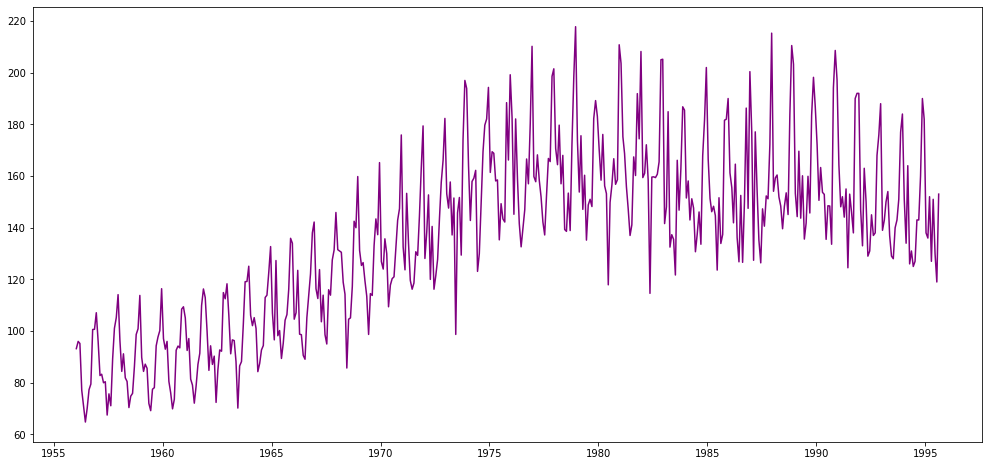

In [6]:
ts = data['Monthly beer production in Australia']
plt.plot(ts, color='purple')

In [7]:
#transformation
ts_log = np.log(ts)

In [8]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='purple',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

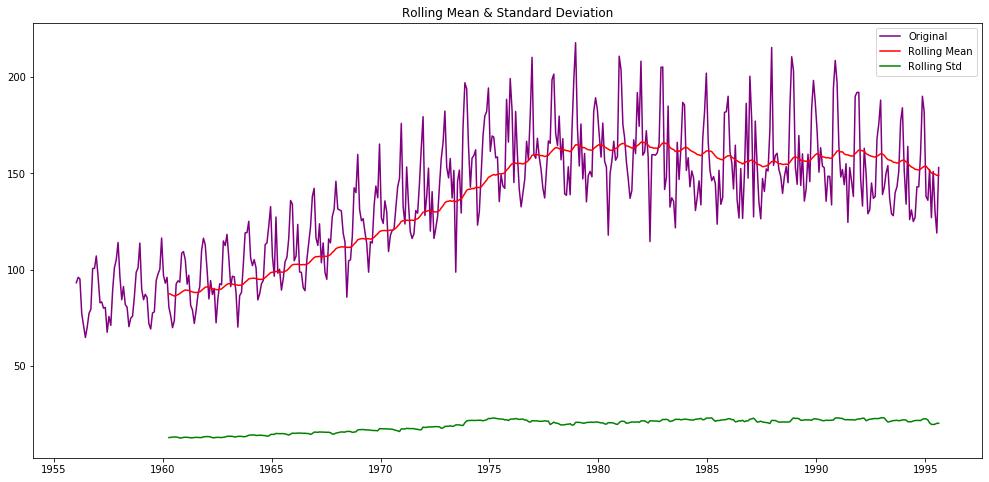

Results of Dickey-Fuller Test:
Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [9]:
test_stationarity(data['Monthly beer production in Australia'])

### Time Series is not stationary

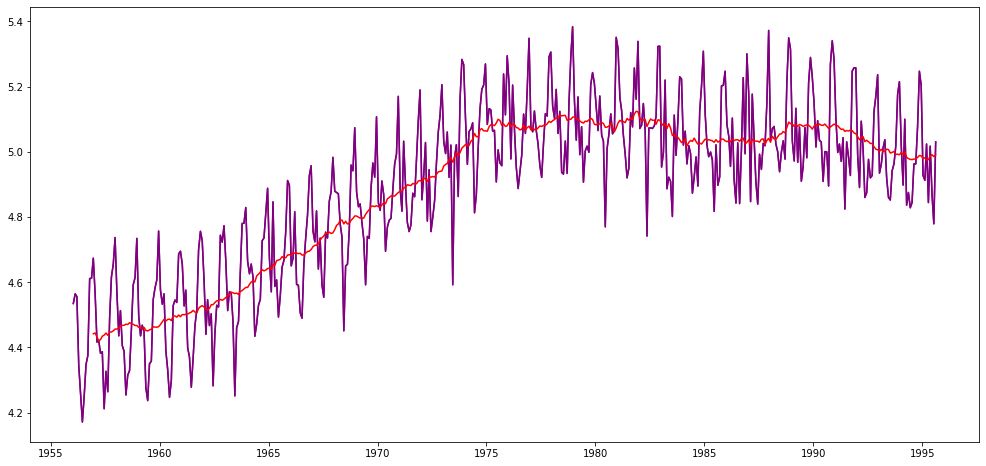

In [10]:
plt.plot(ts_log, color = 'purple');

movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log, color = 'purple')
plt.plot(movingAverage, color='red');

In [11]:
# Get the difference between the moving average and the actual number of passengers
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)
#Remove Nan Values
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1956-12-15    0.231830
1957-01-15    0.118994
1957-02-15   -0.015558
1957-03-15    0.001590
1957-04-15   -0.041908
1957-05-15   -0.047399
1957-06-15   -0.225688
1957-07-15   -0.117442
1957-08-15   -0.173166
1957-09-15    0.045062
Name: Monthly beer production in Australia, dtype: float64

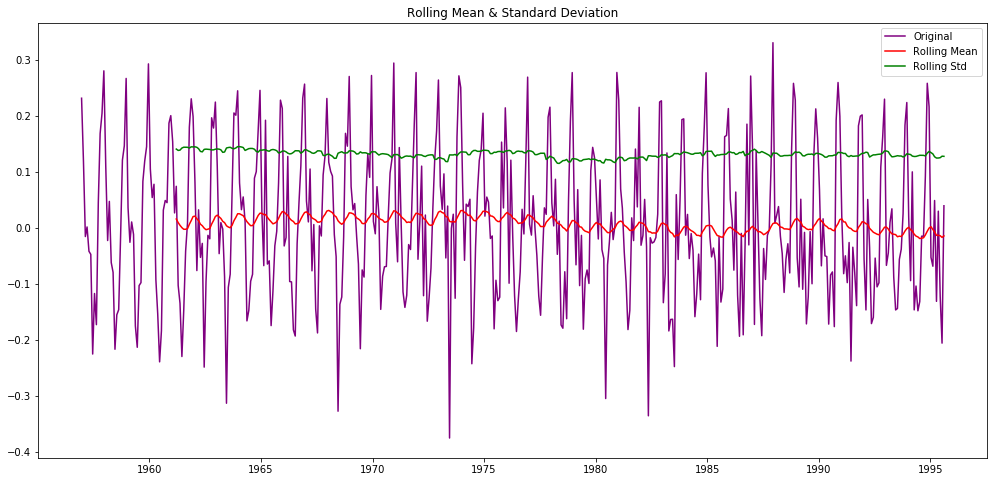

Results of Dickey-Fuller Test:
Test Statistic                  -3.432559
p-value                          0.009898
#Lags Used                      13.000000
Number of Observations Used    451.000000
Critical Value (1%)             -3.444933
Critical Value (5%)             -2.867970
Critical Value (10%)            -2.570195
dtype: float64


In [12]:
test_stationarity(ts_log_mv_diff)

### Time Series is now Stationary

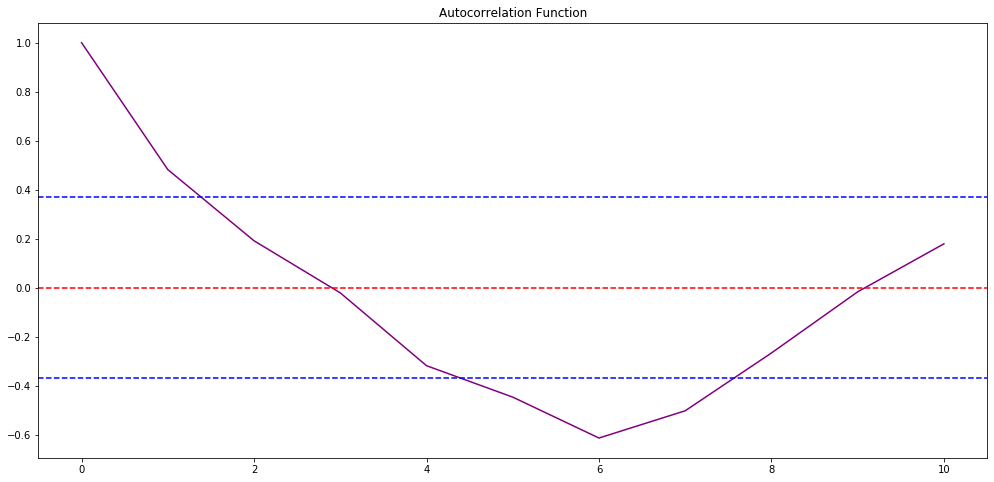

In [13]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags = 10), color = 'purple')
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='blue')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='blue')
plt.title('Autocorrelation Function')
plt.show()

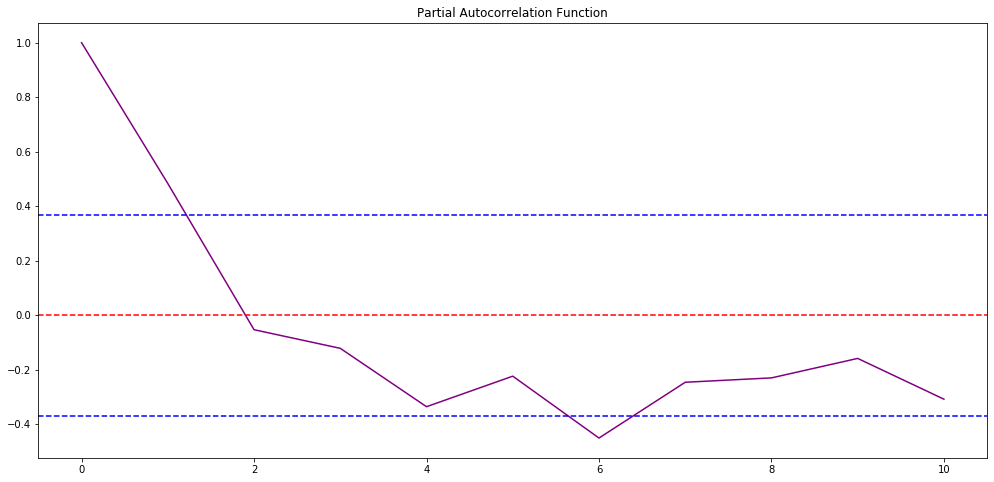

In [14]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags = 10), color = 'purple')
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='blue')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='blue')
plt.title('Partial Autocorrelation Function')
plt.show()

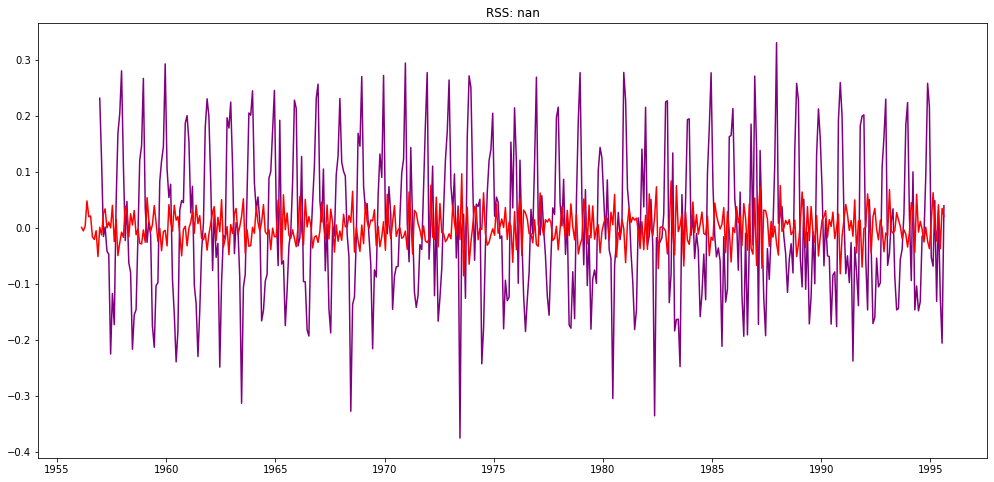

In [15]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_mv_diff, color = 'purple')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2));

In [16]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1956-02-15    0.000936
1956-03-15   -0.005458
1956-04-15    0.003012
1956-05-15    0.048189
1956-06-15    0.019847
dtype: float64

In [17]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1956-02-15    0.000936
1956-03-15   -0.004522
1956-04-15   -0.001510
1956-05-15    0.046680
1956-06-15    0.066527
dtype: float64

In [18]:
predictions_ARIMA_log = pd.Series(ts_log[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1956-01-15    4.534748
1956-02-15    4.535684
1956-03-15    4.530226
1956-04-15    4.533238
1956-05-15    4.581428
dtype: float64

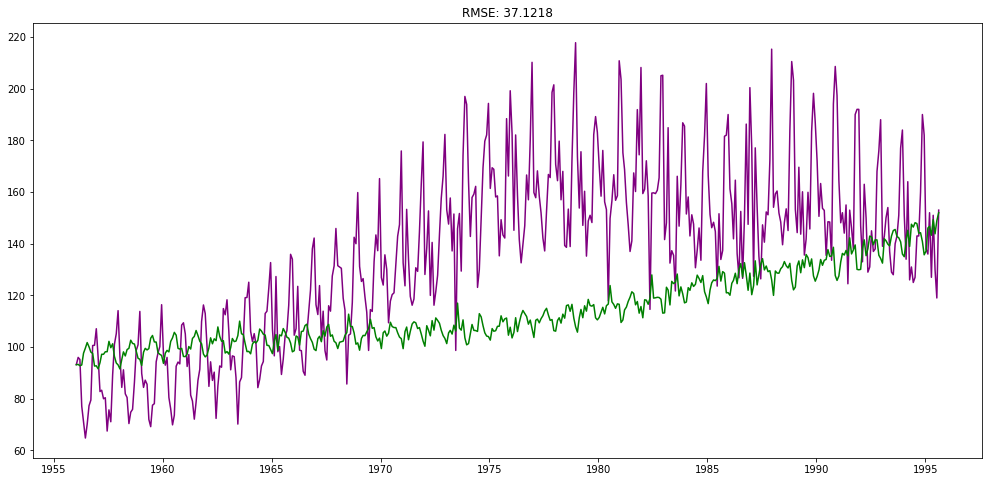

In [19]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts, color = 'purple')
plt.plot(predictions_ARIMA, color = 'green')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)));

### The model is good at predicting the trend but it doesn't captures the seasonality